In [61]:
import pandas as pd
import xgboost as xg
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pl
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import sqlite3

In [67]:
#test set size in months
month = 24

In [3]:
#Street and temp are the tables

sqliteConnection = sqlite3.connect('crime_data')        
data = pd.read_sql_query("""SELECT *
                            FROM street
                            WHERE Month >= 2018-01""", sqliteConnection)  
#data = pd.read_csv('metropolitanstreet.csv')
#data = read_in
#data.head()

In [4]:
lsoatoward = pd.read_csv('LSOAWARD.csv')
lsoatoward[lsoatoward['LAD22NM'].str.contains('Barnet', regex=True)]

,LSOA21CD,LSOA21NM,LSOA21NMW,WD22CD,WD22NM,WD22NMW,LAD22CD,LAD22NM,LAD22NMW,ObjectId
28800,E01000145,Barnet 037A,NaN,E05013631,Childs Hill,NaN,E09000003,Barnet,NaN,28801
28803,E01000140,Barnet 041C,NaN,E05013631,Childs Hill,NaN,E09000003,Barnet,NaN,28804
28806,E01000136,Barnet 038B,NaN,E05013631,Childs Hill,NaN,E09000003,Barnet,NaN,28807
28809,E01000189,Barnet 014D,NaN,E05013637,Edgware,NaN,E09000003,Barnet,NaN,28810
28811,E01000151,Barnet 026B,NaN,E05013632,Colindale North,NaN,E09000003,Barnet,NaN,28812
...,...,...,...,...,...,...,...,...,...,...
29431,E01000315,Barnet 022F,NaN,E05013651,Woodhouse,NaN,E09000003,Barnet,NaN,29432
29432,E01000321,Barnet 012E,NaN,E05013651,Woodhouse,NaN,E09000003,Barnet,NaN,29433
29433,E01000320,Barnet 011D,NaN,E05013651,Woodhouse,NaN,E09000003,Barnet,NaN,29434
29434,E01000318,Barnet 019E,NaN,E05013651,Woodhouse,NaN,E09000003,Barnet,NaN,29435


# Data  formatting

In [6]:
dictionary = lsoatoward[lsoatoward['LAD22NM'].str.contains('Barnet', regex=True)][['LSOA21CD', 'WD22NM']].set_index('LSOA21CD').to_dict()['WD22NM']
dictionary

{'E01000145': 'Childs Hill',
 'E01000140': 'Childs Hill',
 'E01000136': 'Childs Hill',
 'E01000189': 'Edgware',
 'E01000151': 'Colindale North',
 'E01000232': 'Edgware',
 'E01033916': 'Colindale North',
 'E01000234': 'Edgware',
 'E01000154': 'Colindale North',
 'E01000271': 'Barnet Vale',
 'E01000268': 'Barnet Vale',
 'E01000247': 'Barnet Vale',
 'E01000251': 'Barnet Vale',
 'E01000288': 'Barnet Vale',
 'E01000246': 'Barnet Vale',
 'E01000267': 'Barnet Vale',
 'E01000252': 'Barnet Vale',
 'E01000270': 'Barnet Vale',
 'E01000269': 'Barnet Vale',
 'E01000120': 'Brunswick Park',
 'E01000123': 'Brunswick Park',
 'E01000117': 'Brunswick Park',
 'E01000124': 'Brunswick Park',
 'E01000118': 'Brunswick Park',
 'E01000115': 'Brunswick Park',
 'E01000119': 'Brunswick Park',
 'E01000121': 'Brunswick Park',
 'E01000116': 'Brunswick Park',
 'E01000122': 'Brunswick Park',
 'E01000133': 'Burnt Oak',
 'E01000127': 'Burnt Oak',
 'E01000226': 'Burnt Oak',
 'E01000134': 'Burnt Oak',
 'E01000235': 'Burnt 

In [11]:
data = data.sort_values(by=['LSOA code', 'Month'])
monthle = LabelEncoder()
monthle.fit(data['Month'])
data['Month'] = monthle.transform(data['Month'])

#data = data.drop(['Crime ID', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA name', 'Last outcome category', 'Context'], axis=1)
#data = data.groupby(['Month', 'LSOAencoded']).count()
data

,Index,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,ward
4453330,2163,None,0,Metropolitan Police Service,Metropolitan Police Service,-0.145263,51.634650,On or near Brookside South,E01000115,Barnet 009A,Anti-social behaviour,None,None,E01000115
4453331,2164,None,0,Metropolitan Police Service,Metropolitan Police Service,-0.141375,51.635020,On or near Exeter Road,E01000115,Barnet 009A,Anti-social behaviour,None,None,E01000115
4453332,2165,None,0,Metropolitan Police Service,Metropolitan Police Service,-0.145263,51.634650,On or near Brookside South,E01000115,Barnet 009A,Anti-social behaviour,None,None,E01000115
4453333,2166,ed625572cc52bb84656bd583941ca74638e2a4350e53d8...,0,Metropolitan Police Service,Metropolitan Police Service,-0.143468,51.636842,On or near Oak Way,E01000115,Barnet 009A,Vehicle crime,Investigation complete; no suspect identified,None,E01000115
4559507,2163,None,0,Metropolitan Police Service,Metropolitan Police Service,-0.145263,51.634650,On or near Brookside South,E01000115,Barnet 009A,Anti-social behaviour,None,None,E01000115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113513,4069,9ff1d2bd455e802b049ad496d35342bdb4e91c5620d45c...,74,Metropolitan Police Service,Metropolitan Police Service,-0.241827,51.594852,On or near Aerodrome Road,E01033573,Barnet 030F,Violence and sexual offences,Under investigation,None,E01033573
113514,4070,a2339a7431499de5419eb5c75a299fd73d9dc8356bb59a...,74,Metropolitan Police Service,Metropolitan Police Service,-0.241280,51.596899,On or near,E01033573,Barnet 030F,Violence and sexual offences,Under investigation,None,E01033573
113515,4071,bf2263a3e8802413f792af645f3fb43583ed327b4bac46...,74,Metropolitan Police Service,Metropolitan Police Service,-0.241827,51.594852,On or near Aerodrome Road,E01033573,Barnet 030F,Violence and sexual offences,Under investigation,None,E01033573
113516,4072,3f0b215bf57f11cca682c2a9e6d6b1da1689cddca53231...,74,Metropolitan Police Service,Metropolitan Police Service,-0.245803,51.595469,On or near Cottenham Drive,E01033573,Barnet 030F,Violence and sexual offences,Under investigation,None,E01033573


In [14]:
preprocess = data[['Month', 'LSOA code', 'Crime type', 'Index']]
preprocess.sort_values(by=['LSOA code', 'Month'])
preprocess = preprocess.groupby(['LSOA code', 'Month', 'Crime type']).count()
#preprocess = preprocess.reset_index()
preprocess

Index
LSOA code Month Crime type                         
E01000115 0     Anti-social behaviour           108
                Vehicle crime                    36
          1     Violence and sexual offences     36
          2     Anti-social behaviour            36
                Other theft                      36
...                                             ...
E01033573 74    Public order                      3
                Shoplifting                       1
                Theft from the person             1
                Vehicle crime                     1
                Violence and sexual offences      9

[87324 rows x 1 columns]

In [15]:
#This is to group by first LSOAcode and then month to achieve counts of different crimes
processed = preprocess.unstack(level=2)
processed = processed.fillna(0)
processed = processed['Index']
processed

Crime type       Anti-social behaviour  Bicycle theft  Burglary  \
LSOA code Month                                                   
E01000115 0                      108.0            0.0       0.0   
          1                        0.0            0.0       0.0   
          2                       36.0            0.0       0.0   
          3                       72.0            0.0       0.0   
          4                       72.0            0.0       0.0   
...                                ...            ...       ...   
E01033573 70                      35.0            0.0       5.0   
          71                      12.0            0.0      12.0   
          72                       6.0            0.0       3.0   
          73                       6.0            0.0       0.0   
          74                       2.0            2.0       0.0   

Crime type       Criminal damage and arson  Drugs  Other crime  Other theft  \
LSOA code Month                                                               
E01000115 0                            0.0    0.0          0.0          0.0   
          1                            0.0    0.0          0.0          0.0   
          2                            0.0    0.0          0.0         36.0   
          3                            0.0    0.0          0.0          0.0   
          4                            0.0    0.0          0.0          0.0   
...                                    ...    ...          ...          ...   
E01033573 70                          15.0   15.0          5.0          5.0   
          71                           0.0    8.0          0.0          8.0   
          72                           3.0   12.0          0.0          0.0   
          73                           0.0   10.0          0.0          4.0   
          74                           1.0    1.0          0.0          5.0   

Crime type       Possession of weapons  Public order  Robbery  Shoplifting  \
LSOA code Month                                                              
E01000115 0                        0.0           0.0      0.0          0.0   
          1                        0.0           0.0      0.0          0.0   
          2                        0.0           0.0      0.0          0.0   
          3                        0.0           0.0      0.0          0.0   
          4                        0.0           0.0      0.0          0.0   
...                                ...           ...      ...          ...   
E01033573 70                       0.0          10.0      0.0          5.0   
          71                       0.0          12.0      4.0          0.0   
          72                       0.0          24.0      0.0          0.0   
          73                       0.0          18.0      0.0          0.0   
          74                       0.0           3.0      0.0          1.0   

Crime type       Theft from the person  Vehicle crime  \
LSOA code Month                                         
E01000115 0                        0.0           36.0   
          1                        0.0            0.0   
          2                        0.0            0.0   
          3                        0.0           36.0   
          4                        0.0            0.0   
...                                ...            ...   
E01033573 70                       0.0           10.0   
          71                       0.0            0.0   
          72                       0.0            0.0   
          73                       0.0            0.0   
          74                       1.0            1.0   

Crime type       Violence and sexual offences  
LSOA code Month                                
E01000115 0                               0.0  
          1                              36.0  
          2                              36.0  
          3                              36.0  
          4                              36.0  
...    

In [ ]:
processed[39:76]

In [ ]:
processed.index

In [16]:
#Here the target column is created and the Burglary values are shifted by 1 index, such that for each month, gets
#the previous month's burglary amount. Then the first months are dropped, since we have garbage in those fields.
processed['target'] = -1
prevburglary = -1
for index in reversed(processed.index):
    if(prevburglary == -1):
        prevburglary = processed['Burglary'][index[0]][index[1]]
    else:
        processed['target'][index[0]][index[1]] = prevburglary
        prevburglary = processed['Burglary'][index[0]][index[1]]

processed

Crime type       Anti-social behaviour  Bicycle theft  Burglary  \
LSOA code Month                                                   
E01000115 0                      108.0            0.0       0.0   
          1                        0.0            0.0       0.0   
          2                       36.0            0.0       0.0   
          3                       72.0            0.0       0.0   
          4                       72.0            0.0       0.0   
...                                ...            ...       ...   
E01033573 70                      35.0            0.0       5.0   
          71                      12.0            0.0      12.0   
          72                       6.0            0.0       3.0   
          73                       6.0            0.0       0.0   
          74                       2.0            2.0       0.0   

Crime type       Criminal damage and arson  Drugs  Other crime  Other theft  \
LSOA code Month                                                               
E01000115 0                            0.0    0.0          0.0          0.0   
          1                            0.0    0.0          0.0          0.0   
          2                            0.0    0.0          0.0         36.0   
          3                            0.0    0.0          0.0          0.0   
          4                            0.0    0.0          0.0          0.0   
...                                    ...    ...          ...          ...   
E01033573 70                          15.0   15.0          5.0          5.0   
          71                           0.0    8.0          0.0          8.0   
          72                           3.0   12.0          0.0          0.0   
          73                           0.0   10.0          0.0          4.0   
          74                           1.0    1.0          0.0          5.0   

Crime type       Possession of weapons  Public order  Robbery  Shoplifting  \
LSOA code Month                                                              
E01000115 0                        0.0           0.0      0.0          0.0   
          1                        0.0           0.0      0.0          0.0   
          2                        0.0           0.0      0.0          0.0   
          3                        0.0           0.0      0.0          0.0   
          4                        0.0           0.0      0.0          0.0   
...                                ...           ...      ...          ...   
E01033573 70                       0.0          10.0      0.0          5.0   
          71                       0.0          12.0      4.0          0.0   
          72                       0.0          24.0      0.0          0.0   
          73                       0.0          18.0      0.0          0.0   
          74                       0.0           3.0      0.0          1.0   

Crime type       Theft from the person  Vehicle crime  \
LSOA code Month                                         
E01000115 0                        0.0           36.0   
          1                        0.0            0.0   
          2                        0.0            0.0   
          3                        0.0           36.0   
          4                        0.0            0.0   
...                                ...            ...   
E01033573 70                       0.0           10.0   
          71                       0.0            0.0   
          72                       0.0            0.0   
          73                       0.0            0.0   
          74                       1.0            1.0   

Crime type       Violence and sexual offences  target  
LSOA code Month                                        
E01000115 0                               0.0       0  
          1                              36.0       0  
          2                              36.0       0  
          3                              36.0       0  
       

In [17]:
#Here we reset the index, such that the LSOAcodes and months no longer are indexes, so that we can use them as features.
processed = processed.reset_index().sort_values(by=['Month', 'LSOA code'])
processed

Crime type,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target
0,E01000115,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0
74,E01000116,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,36.0,0.0,108
149,E01000117,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,36
224,E01000118,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,72
299,E01000119,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15492,E01000322,74,6.0,0.0,1.0,1.0,0.0,1.0,4.0,0.0,1.0,1.0,2.0,1.0,4.0,3.0,0
15567,E01000323,74,3.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,4.0,1.0,3.0,0.0,3.0,6.0,36
15642,E01000324,74,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0
15717,E01033572,74,13.0,0.0,4.0,1.0,0.0,0.0,3.0,0.0,5.0,1.0,1.0,0.0,0.0,7.0,0


In [19]:
for index in processed.index:
    if(processed['Month'][index] == max(processed['Month'])):
        processed = processed.drop([index])
processed

Crime type,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target
0,E01000115,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0
74,E01000116,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,36.0,0.0,108
149,E01000117,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,36
224,E01000118,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,72
299,E01000119,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15491,E01000322,73,6.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,4.0,6.0,1
15566,E01000323,73,2.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,6.0,4.0,0.0,4.0,2.0,12.0,0
15641,E01000324,73,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
15716,E01033572,73,20.0,4.0,8.0,4.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,4


In [20]:
processed['ward'] = processed['LSOA code']
processed = processed.replace({"ward": dictionary})
processed

Crime type,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target,ward
0,E01000115,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0,Brunswick Park
74,E01000116,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,36.0,0.0,108,Brunswick Park
149,E01000117,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,36,Brunswick Park
224,E01000118,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,72,Brunswick Park
299,E01000119,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0,Brunswick Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15491,E01000322,73,6.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,4.0,6.0,1,Woodhouse
15566,E01000323,73,2.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,6.0,4.0,0.0,4.0,2.0,12.0,0,Woodhouse
15641,E01000324,73,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,Woodhouse
15716,E01033572,73,20.0,4.0,8.0,4.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,4,E01033572


In [24]:
processed['ward'].unique()
notward = ['E01000125', 'E01000155', 'E01000148', 'E01000262', 'E01033572', 'E01033573']
for index in processed.index:
    if(processed['ward'][index] in notward):
        processed = processed.drop([index])
processed

Crime type,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target,ward
0,E01000115,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0,Brunswick Park
74,E01000116,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,36.0,0.0,108,Brunswick Park
149,E01000117,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,36,Brunswick Park
224,E01000118,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,72,Brunswick Park
299,E01000119,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0,Brunswick Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15341,E01000320,73,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,2,Woodhouse
15416,E01000321,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,1,Woodhouse
15491,E01000322,73,6.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,4.0,6.0,1,Woodhouse
15566,E01000323,73,2.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,6.0,4.0,0.0,4.0,2.0,12.0,0,Woodhouse


In [26]:
#encode the wards
wardlenc = LabelEncoder()
wardlenc.fit(processed['ward'])
processed['wardenc'] = wardlenc.transform(processed['ward'])
processed

Crime type,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target,ward,wardenc
0,E01000115,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0,Brunswick Park,1
74,E01000116,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,36.0,0.0,108,Brunswick Park,1
149,E01000117,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,36,Brunswick Park,1
224,E01000118,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,72,Brunswick Park,1
299,E01000119,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0,Brunswick Park,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15341,E01000320,73,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,2,Woodhouse,23
15416,E01000321,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,1,Woodhouse,23
15491,E01000322,73,6.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,4.0,6.0,1,Woodhouse,23
15566,E01000323,73,2.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,6.0,4.0,0.0,4.0,2.0,12.0,0,Woodhouse,23


<AxesSubplot:>

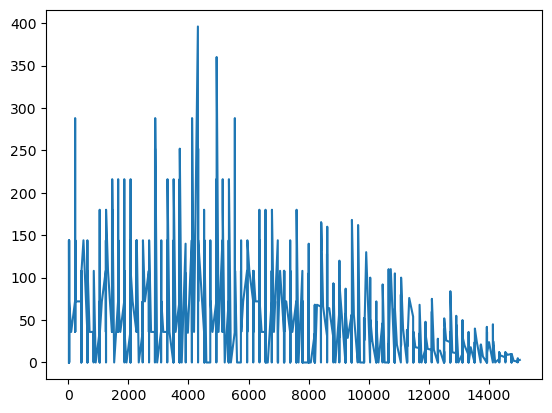

In [27]:
#By changing the lsoacode variable, you can see different lsoacode's burglary rate.
Lsoacode = 3
processed = processed.reset_index()
processed[processed['wardenc'] == Lsoacode]['target'].plot()

In [28]:
processed['Year'] = np.floor(processed['Month'] / 12)
processed['Month'] = processed['Month'] % 12
processed

Crime type,index,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,...,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target,ward,wardenc,Year
0,0,E01000115,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,36.0,0.0,0,Brunswick Park,1,0.0
1,74,E01000116,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,...,36.0,0.0,0.0,0.0,36.0,0.0,108,Brunswick Park,1,0.0
2,149,E01000117,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,36.0,0.0,36,Brunswick Park,1,0.0
3,224,E01000118,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,36.0,0.0,72,Brunswick Park,1,0.0
4,299,E01000119,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,72.0,0.0,0,Brunswick Park,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15133,15341,E01000320,1,2.0,0.0,2.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,6.0,4.0,2,Woodhouse,23,6.0
15134,15416,E01000321,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,8.0,1,Woodhouse,23,6.0
15135,15491,E01000322,1,6.0,0.0,4.0,0.0,0.0,0.0,2.0,...,2.0,0.0,2.0,0.0,4.0,6.0,1,Woodhouse,23,6.0
15136,15566,E01000323,1,2.0,0.0,0.0,10.0,0.0,0.0,10.0,...,6.0,4.0,0.0,4.0,2.0,12.0,0,Woodhouse,23,6.0


In [104]:
y_true = processed[(processed['Month'] + processed['Year']*12) >= 30]['target']
len(y_true)
dataframeplot = processed[['target']][-24*month:]
dataframeplot['wardenc'] = processed['wardenc'][-24*month:]

In [30]:
#Here we are scaling the features, to accomodate XGBoost's requirements for features. We are creating vectors for machine learning.
features = ['wardenc', 'Year', 'Month', 'Anti-social behaviour', 'Bicycle theft', 'Burglary', 'Criminal damage and arson', 
            'Drugs', 'Other crime', 'Other theft', 'Possession of weapons', 'Public order', 'Robbery', 'Shoplifting',
           'Theft from the person', 'Vehicle crime', 'Violence and sexual offences']
scaler = MinMaxScaler()
array = processed[features]
array[features] = scaler.fit_transform(processed[features])
array

/var/folders/17/shmyj09d3k5fdl2f0sgy54t40000gn/T/ipykernel_1547/1909462703.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  array[features] = scaler.fit_transform(processed[features])


Crime type,wardenc,Year,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
0,0.043478,0.0,0.000000,0.058824,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
1,0.043478,0.0,0.000000,0.019608,0.0,0.066667,0.032258,0.0,0.0,0.000000,0.0,0.050000,0.000000,0.000000,0.000000,0.050000,0.000000
2,0.043478,0.0,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
3,0.043478,0.0,0.000000,0.019608,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
4,0.043478,0.0,0.000000,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15133,1.000000,1.0,0.090909,0.001089,0.0,0.003704,0.000000,0.0,0.0,0.002090,0.0,0.000000,0.000000,0.000000,0.000000,0.008333,0.005556
15134,1.000000,1.0,0.090909,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008333,0.011111
15135,1.000000,1.0,0.090909,0.003268,0.0,0.007407,0.000000,0.0,0.0,0.001045,0.0,0.002778,0.000000,0.000868,0.000000,0.005556,0.008333
15136,1.000000,1.0,0.090909,0.001089,0.0,0.000000,0.008961,0.0,0.0,0.005225,0.0,0.008333,0.009259,0.000000,0.004115,0.002778,0.016667


In [31]:
len(array), len(y_true)

(15138, 9003)

In [32]:
y_true.reset_index()
y_true

6135      0
6136      0
6137     72
6138      0
6139     36
         ..
15133     2
15134     1
15135     1
15136     0
15137     0
Name: target, Length: 9003, dtype: int64

In [33]:
processed.sort_values(by=['Year', 'Month', 'wardenc'])
processed[(processed['Month'] + processed['Year']*12) >= 30]

Crime type,index,LSOA code,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,...,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,target,ward,wardenc,Year
6135,104,E01000116,6,36.0,0.0,36.0,0.0,0.0,0.0,0.0,...,36.0,0.0,0.0,0.0,36.0,144.0,0,Brunswick Park,1,2.0
6136,179,E01000117,6,0.0,0.0,0.0,36.0,0.0,0.0,0.0,...,0.0,0.0,0.0,36.0,72.0,216.0,0,Brunswick Park,1,2.0
6137,254,E01000118,6,36.0,0.0,0.0,36.0,36.0,0.0,0.0,...,0.0,72.0,0.0,0.0,36.0,72.0,72,Brunswick Park,1,2.0
6138,327,E01000119,6,0.0,0.0,36.0,0.0,0.0,0.0,0.0,...,36.0,0.0,0.0,0.0,0.0,0.0,0,Brunswick Park,1,2.0
6139,402,E01000120,6,72.0,0.0,36.0,0.0,0.0,0.0,0.0,...,0.0,36.0,36.0,0.0,36.0,108.0,36,Brunswick Park,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15133,15341,E01000320,1,2.0,0.0,2.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,6.0,4.0,2,Woodhouse,23,6.0
15134,15416,E01000321,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,8.0,1,Woodhouse,23,6.0
15135,15491,E01000322,1,6.0,0.0,4.0,0.0,0.0,0.0,2.0,...,2.0,0.0,2.0,0.0,4.0,6.0,1,Woodhouse,23,6.0
15136,15566,E01000323,1,2.0,0.0,0.0,10.0,0.0,0.0,10.0,...,6.0,4.0,0.0,4.0,2.0,12.0,0,Woodhouse,23,6.0


In [63]:
len(processed['wardenc'].unique())

24

In [68]:
#Assigning the training and testing datasets, with a circa 80-20 split
X_train = array[:-24*(month+1)]
y_train = processed['target'][:-24*(month+1)]
X_test = array[-24*month:]
y_test = processed['target'][-24*month:]
len(X_train), len(X_test), len(y_train), len(y_test)

(14538, 576, 14538, 576)

In [83]:
processed[features].head(10)

Crime type,wardenc,Year,Month,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
0,1,0.0,0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0
1,1,0.0,0,36.0,0.0,36.0,36.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,36.0,0.0
2,1,0.0,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0
3,1,0.0,0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0
4,1,0.0,0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0
5,1,0.0,0,0.0,0.0,72.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0
6,1,0.0,0,36.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
7,1,0.0,0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0
8,1,0.0,0,36.0,0.0,36.0,0.0,36.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0
9,1,0.0,0,72.0,0.0,144.0,144.0,0.0,0.0,216.0,0.0,108.0,36.0,396.0,72.0,108.0,144.0


# Model setup

In [69]:
# create model
model = xg.XGBRFRegressor(n_estimators=200, max_depth=12, learning_rate=1)#objective='binary:logistic')
# fit model
model.fit(X_train, y_train)
# make predictions
preds = model.predict(X_test)
preds

array([ 4.91059  ,  4.6259594,  8.332599 ,  3.1709733,  6.760516 ,
        4.4182057,  3.5843399,  4.36202  ,  3.1357436,  3.8809536,
        3.0773816,  4.032767 ,  5.123375 ,  7.994313 ,  3.8726938,
        3.888405 ,  6.3433433,  4.472724 ,  4.0275664,  3.8898818,
        3.1870716,  4.188705 ,  4.0510473,  3.2882426,  3.0882468,
        3.1527116,  3.999321 ,  2.9753382,  3.1600316,  3.9233658,
        4.129434 ,  3.9863653,  3.0926812,  3.002509 ,  3.0248585,
       11.264346 ,  5.202518 ,  5.157628 ,  4.631499 ,  4.0358076,
        4.21985  ,  3.9273992,  3.110207 ,  4.2052417,  4.504666 ,
        4.0387025,  3.3983624,  3.1458259,  3.1720245,  3.1399875,
        3.9874177,  3.6776469,  3.2719913,  3.5022938,  3.0727642,
        4.457143 ,  5.3027606,  3.868335 ,  3.2488232,  3.768768 ,
        3.1836014,  4.662124 ,  4.2856007, 10.329233 ,  4.835921 ,
        4.875578 ,  3.867402 ,  3.9518685,  3.151486 ,  3.1899903,
        4.4102445,  3.0659826,  3.9624546,  3.096638 ,  4.1756

In [70]:
#preds = scaler.inverse_transform(preds.reshape(-1, 1))
#preds.reshape()
#preds.max()
X_test.shape, y_true.shape, preds.shape

((576, 17), (9003,), (576,))

In [66]:
#Here we get the mean absolute error of the predictions compared to the truth values on the test set.
mae = mean_absolute_error(y_test, preds)
mae

2.3123546462092133

In [72]:
#Create output dataframe
output = processed[['Year', 'Month', 'wardenc', 'target']][-24*month:]
output['predictions'] = preds
output

Crime type,Year,Month,wardenc,target,predictions
14562,5.0,11,12,3,4.910590
14563,5.0,11,12,0,4.625959
14564,5.0,11,12,0,8.332599
14565,5.0,11,12,15,3.170973
14566,5.0,11,12,15,6.760516
...,...,...,...,...,...
15133,6.0,1,23,2,4.526097
15134,6.0,1,23,1,4.728491
15135,6.0,1,23,1,4.821121
15136,6.0,1,23,0,5.263819


In [ ]:
#Here is a plot of the predictions
pd.Series(preds.ravel()).plot()

In [ ]:
output[output['LSOAencoded'] == 0][['predictions', 'target']].plot()

In [ ]:
sns.lineplot(data=output, x="Month", y="predictions")

In [ ]:
#Here is a plot of the true values
y_true.plot()

# Shap values

In [49]:
import shap

In [50]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 349it [00:37,  7.35it/s]                                 


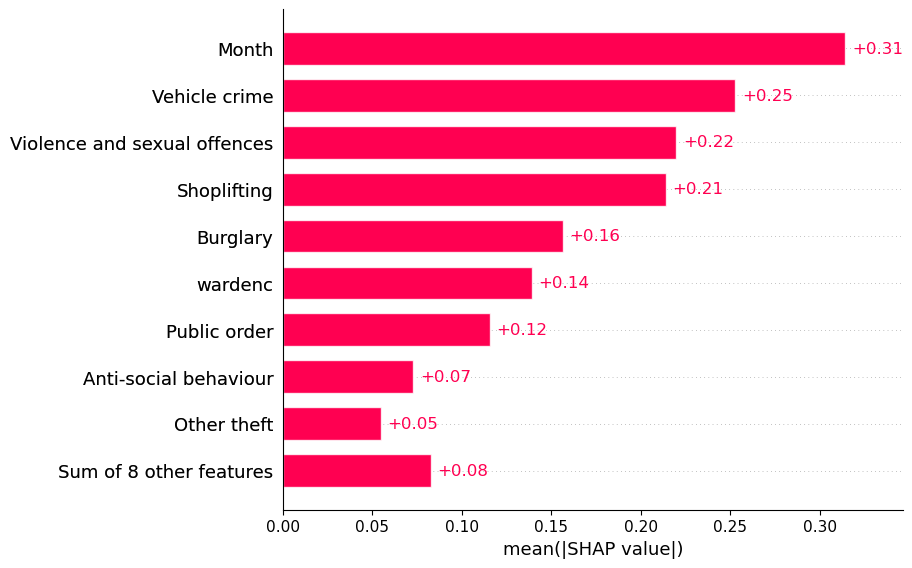

In [86]:
#Shap value bar chart
pl.figure(figsize=(10,6))
shap.plots.bar(shap_values, show=False)
pl.savefig("shap_mean.png")

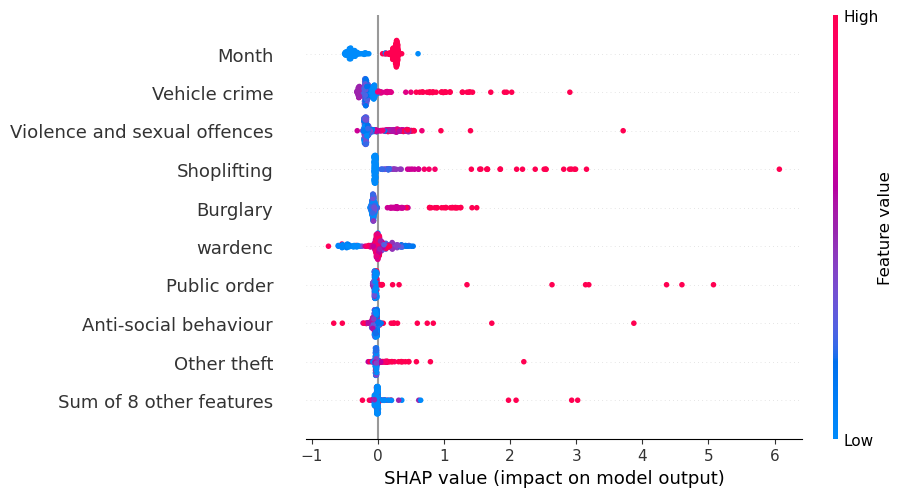

In [52]:
#Beeswarm plot
shap.plots.beeswarm(shap_values)

In [4]:
#Shap violin plot
shap.summary_plot(shap_values, plot_type='violin', show=False)
pl.savefig("shap_violin.png")

NameError: name 'shap' is not defined

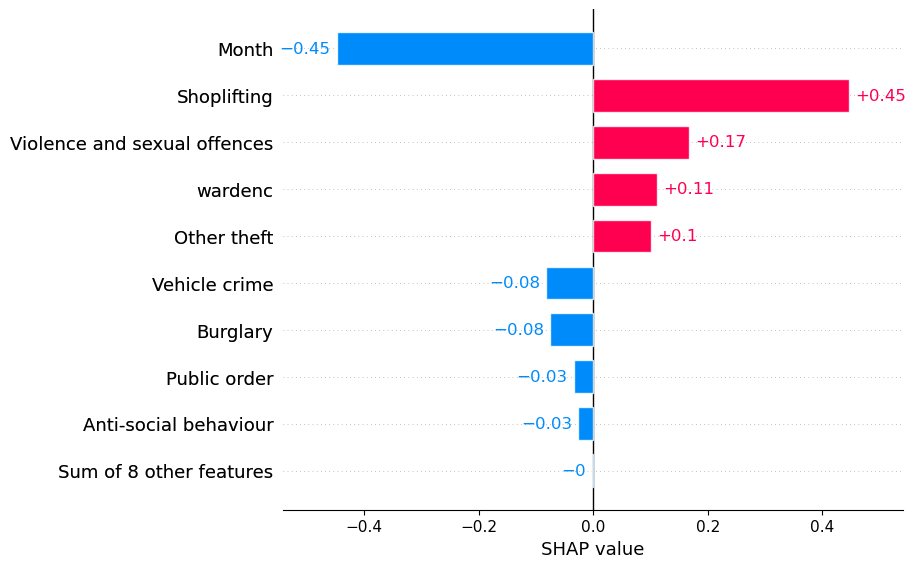

In [54]:
#Shap local bar plot
shap.plots.bar(shap_values[0])

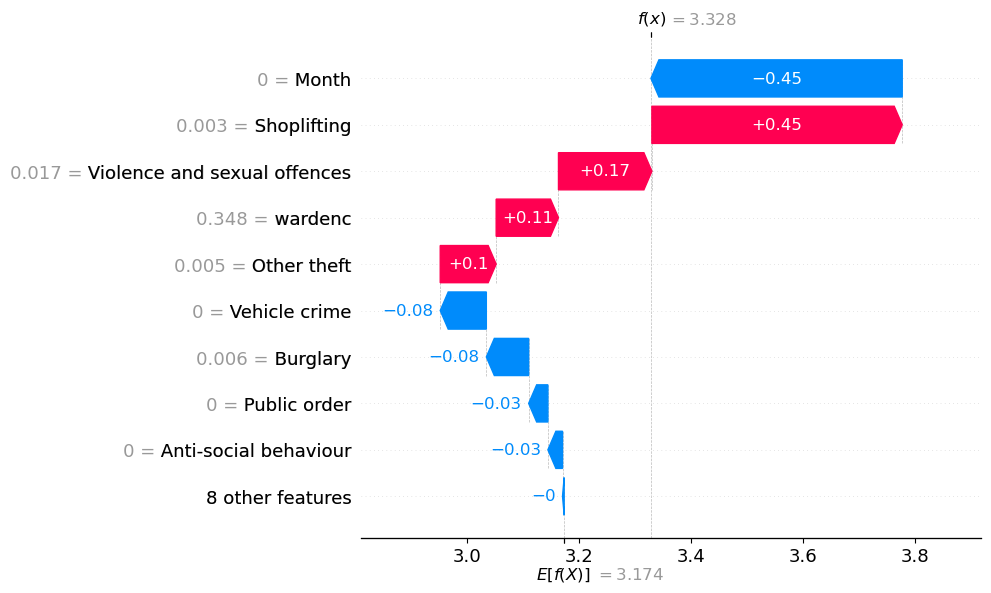

In [55]:
#Shap waterfall plot
shap.plots.waterfall(shap_values[0])

In [ ]:
#Shap force plot
#initjs()
shap.plots.force(shap_values[0])

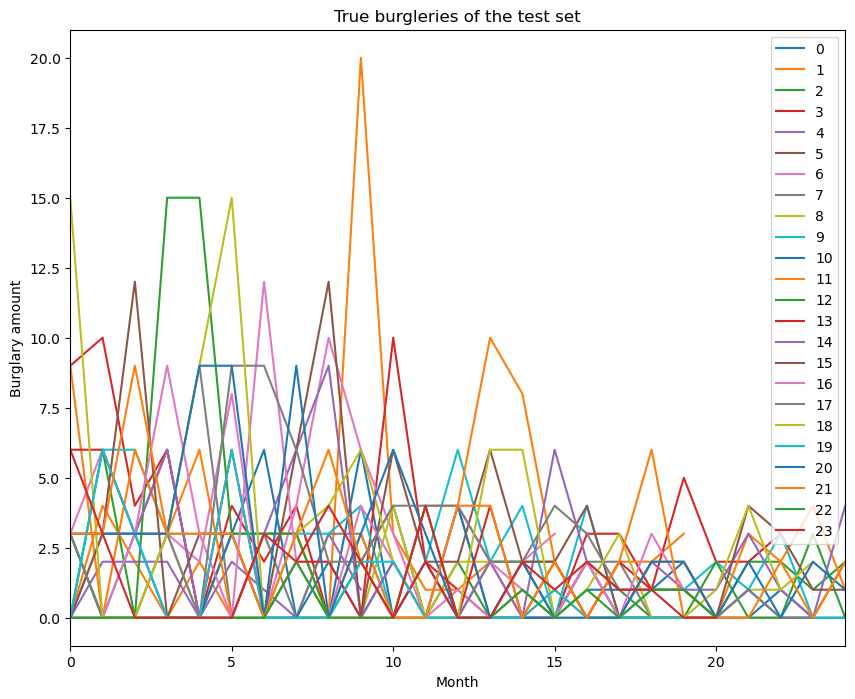

In [125]:
dataframeplot = dataframeplot.reset_index()[['wardenc', 'target']]
fig, ax = pl.subplots(figsize=(10,8))
ax.set_xlim(0,24)
ax.set_xlabel('Month')
ax.set_ylabel('Burglary amount')
ax.set_title('True burgleries of the test set')
for i in range(0,24):
    ax.plot(dataframeplot[dataframeplot['wardenc'] == i].reset_index()['target'])
listenc = []
for i in range(0,24):
    listenc.append(i)
ax.legend(listenc)
pl.savefig('test.png')